# Iris Automation Public-Facing Challenge
## Eric Graves
Started 06/03/2019

### Challenge Text:
There are 31 images in the dataset. They are all taken from drones in a range of different environments.
Provide us with as much contextual awareness about these environments as you possibly can. We want to automatically understand everything about the 
scene in the way a human pilot might. Here are a few of the items you might consider adding to your output:
1) Horizon line detection
2) Cloud detection
3) Lighting conditions (where the sun is located)
4) Daytime/nighttime/dusk
5) Weather conditions (rain, hail, fog, thunderstorm, etc)
6) Setting (urban, rural, over water, desert, forest, mountains, etc)

One example of a basic solution is shown in examplesolution_image29.pdf but feel free to improvise on that.

Solve part of it or solve the whole thing. Use "traditional" algorithms or deep learning. We don't mind as long as it works.
If you think you have actually solved this to a sufficient level, email your code to thechallenge@irisonboard.com and we will give you an interview.

Good luck!

### My Plan:
Scene classification
- Don't use TF until later, see what can be accomplished with image processing and smart assumptions
- Image classifier may be the best option for scene recognition
- Try to guess scene based on pixel variance first (assume day=high, night=bimodal, dawn/dusk=more 'red')
Horizon
- Hough transform and find long line (obvious way)
- look for vertical change in pixel values (doesnt work in fog, sideways images)
Lighting
- Close to scene classification, use color values, 
- Look for the sun (probably an overexposed area if present in image
- 

### Tools:
Canny Edge Detection - edge mapping
Hough Transform - feature recognition
Watershed segmentation - segment by color
Otsu Thresholding - good for bimodal distributions
Template matching? - probably not useful in this case
Image classifier in TF - look into later

### Notes:
Other test images are in Projects/iris_images/


In [13]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
from pathlib import Path
from PIL import Image
import math
import time
%matplotlib inline

## Add test images to array
working_dir = os.getcwd()
print("Current working directory: " + working_dir)
pngs = []

for root, dirs, files in os.walk(u"."):
    path = root.split(os.sep)
    #print((len(path) - 1) * '---', os.path.basename(root))
    for file in files:
        #print(len(path) * '---', file)
        if file.endswith('.png') or file.endswith('.PNG'): # Read both types: further testing needed to make sure numpy is okay with reading both
            png_path =  str(os.path.realpath(root)) + "/" +  str(file)
            pngs.append(Path(png_path))

print("Found : " + str(len(pngs)) + " images in " + str(Path(working_dir)))



Current working directory: C:\Users\Eric graves\Desktop\Iris_Challenge
Found : 1 images in C:\Users\Eric graves\Desktop\Iris_Challenge


In [14]:
# Visualize image color components
# Not needed in production, but useful to debug image thresholds

# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib import colors

# vis_img = img # Change to test different images

# r, g, b = cv.split(vis_img)
# fig = plt.figure()
# axis = fig.add_subplot(1, 1, 1, projection="3d")

# pixel_colors = vis_img.reshape((np.shape(vis_img)[0]*np.shape(vis_img)[1], 3))
# norm = colors.Normalize(vmin=-1.,vmax=1.)
# norm.autoscale(pixel_colors)
# pixel_colors = norm(pixel_colors).tolist()

# axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
# axis.set_xlabel("Red")
# axis.set_ylabel("Green")
# axis.set_zlabel("Blue")
# plt.show()

In [15]:
# Watershed Segmentation using Otsu threshold
def watershed_seg(img_seg):
    
    # Image Segmentation using Watershed Algorithm
    # -- Looks for dark spots in the image and shrinks and marks them, then builds out from marked centers to segment the image
    # -- Only works on single color channel images (B/W used here)

    # Threshold
    # -- Determine threshold automatically using Otsu method
    # -- Alternate method: (cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
#     img_seg = cv.imread(IMAGE_PATH)
    gray = cv.cvtColor(img_seg,cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU) 

    # Noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

    # Find sure background area
    sure_bg = cv.dilate(opening,kernel,iterations=3)

    # Find sure foreground area
    # -- Can tune 0.7*dist_transform.max() to fit image set: larger values (than 0.7) give larger areas and vice versa
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0) 

    # Find unknown region
    # -- Not obviously fg or bg
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1 

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    # Generate final Segmented Mask (markers)
    markers = cv.watershed(img_seg,markers)

    # Generate visual representation of segmentation (useful for demonstration/testing)
    img[markers == -1] = [255,0,0] # Outline watershed edge in red (r:255, g:0, b:0)
    return markers

In [16]:
# Probabilistic Hough line 
def hough_line_p(img):
    
    plt.subplot(231),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    
    # Convert to 8-bit image
    img = img.astype(np.uint8)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    edges = cv.Canny(gray,50,150,apertureSize = 3)
    
    # Set max/min line lengths
    #-- Based on image size: horizon should (theoretically) stretch across an entire dimension of the screen
    #-- Max Length: sqrt(height^2 + len^2)
    #-- Min Length: min[height, len], maybe divide by 2 so that we almost always return something
    #-- Set maximum gap between lines as some percentage of image len/height
#     [l,h,c] = img.shape
#     min_side = min(l,h)
#     minLineLength = min_side / 2
#     maxLineGap = 0.5*min_side

    minLineLength = 100
    maxLineGap = 100
    
    
    lines = cv.HoughLinesP(edges,1,np.pi/180,10,minLineLength,maxLineGap)
    for x1,y1,x2,y2 in lines[0]:
        cv.line(img,(x1,y1),(x2,y2),(0,255,0),2)
        
    return img 

In [17]:
# Method from "A Hierachical Horizon Detection Algorithm" - Yu-Fei Shen et al.

def hierarchical_horizon(img):
    # Blur with low pass filter: 
    #-- Gaussian sigma = num_rows / 50
    [rows,cols] = img.shape[:2]
    
    img_bl = cv.medianBlur(img, 5)

    plt.subplot(221),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(222),plt.imshow(img_bl,cmap = 'gray')
    plt.title('Blurred Image'), plt.xticks([]), plt.yticks([])

    # Canny edge detector
    #-- Keep egdes with stregth > 5/num_cols


    # Hough Transform 
    
    return 

C:\Users\Eric graves\Desktop\Iris_Challenge\image6.png


NameError: name 'wtshd_img' is not defined

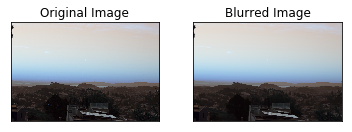

In [18]:

# Process each image in pngs
for img_path in pngs:
    
    # Preprocessing of the image
    #-- Watershed needs b/w
    #-- 
    
    # Canny edge
    print(img_path)
    img = cv.imread(str(img_path), cv.IMREAD_UNCHANGED) # imread needs filename as a string
    #edges = cv.Canny(img,100,2)
    
    new_test = hierarchical_horizon(img) # testing hierachical method above
    
    # Watershed
    #wtshd_img = watershed_seg(img)
    
    # Linear transform (includes Canny edge)
    #lines_img = hough_line_p(img)
    print(wtshd_img.shape)
    print(wtshd_img.dtype)
    #lines_wtshd = hough_line_p(wtshd_img)
    
    
#     plt.subplot(231),plt.imshow(img,cmap = 'gray')
#     plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#     plt.subplot(232),plt.imshow(edges,cmap = 'gray')
#     plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
#     plt.subplot(233),plt.imshow(wtshd_img,cmap = 'gray')
#     plt.title('Watershed Image'), plt.xticks([]), plt.yticks([])
#     plt.subplot(234),plt.imshow(lines_img,cmap = 'gray')
#     plt.title('Hough Lines Image'), plt.xticks([]), plt.yticks([])
#     plt.subplot(235),plt.imshow(wtshd_img,cmap = 'gray')
#     plt.title('Hough Lines on Watershed Image'), plt.xticks([]), plt.yticks([])
    
    
    # Guess Lighting
    
        # Is the Sun visible? 
        #-- probably an overexposed region
        
        # Guess Cloud Cover 
        #-- how "blue" is the sky?
    
    # Look for Horizon
        
        # Hough Transform? or better way?
    
    # Look for Land Features
    
        # From horizon info, is it flat or no?
        
        # From edge-maps, are there roads?
        
        # Are there buildings? (lots of straight lines, maybe parallel)
    
    
    # Guess Setting
    
    
    # Wait before running next image (for my sanity)
    